# Tutorial: Setting Up Star Formation-Rate Dictionary

This notebook demonstrates how to construct star formation rate dictionaries (`sfr_dict`), plot them, and highlight key considerations.

The star formation rate (SFR) history is stored in a dictionary called `sfr_dict`. The dictionary includes entries for the global star formation rate (`starformation_rate_array`), information about the bins in which this star formation rate is defined (either based on lookback time, `lookback_time_bin_edges`, or based on redshift, `redshift_bin_edges`) and, optionally, information about the metallicity distribution (`metallicity_distribution_array`) and its bins (`metallicity_bin_edges`). This information has to be provided in arrays, and they are used as such in the convolution. That means that any normalisation over the (global) range is the responsibility of the user. 

An example `sfr_dict` looks like this

```python
sfr_dict = {
    'lookback_time_bin_edges': np.arange(0, 10, 1) * u.Gyr,
    'starformation_rate_array': np.ones(9) * u.Msun / u.yr
    'metallicity_bin_edges': np.array([0.001, 0.01, 0.1, 1]),
    'metallicity_distribution_array': np.ones(9,3) * 0.33
}
```

For more details on both the global star formation rate information and the metallicity information, see the following sections.

### Configuring the Global Star Formation Rate
The first step to configuring the `sfr_dict` is by providing information about the global star formation rate over a range of times. 

To configure the SFR history, provide the `sfr_dict` with :

- `lookback_time_bin_edges` or `redshift_bin_edges`: 1-D array of bin edges for lookback time (astropy units are required here), or redshift.
- `starformation_array`: 1-D array of SFR values at bin centers. Must have astropy units (but they can be anything, to support different types of SFR information) and must be one element shorter than the bin edges array.

We can perform a convolution based on only a global star formation rate, so providing the above-mentioned entries will be enough for a functioning convolution.

Some functions to generate known SFR distributions are provided in `syntheticstellarpopconvolve.starformation_rate_distributions.py`.

### Adding Metallicity Dependence (Optional)
Often, however, we want to convolve our stellar population information taking into account a range of metallicities. This is supported if you include the following information to the `sfr_dict`:

- `metallicity_bin_edges`: 1-D array of metallicity bin edges.
- `metallicity_distribution_array`: 2-D array of metallicity distribution as a function of time/redshift and metallicity. Must have dimensions:
  - One less than `lookback_time_bin_edges` or `redshift_bin_edges` in time dimension (0).
  - One less than `metallicity_bin_edges` in metallicity dimension (1).


  e.g. `metallicity_distribution_array.shape = (<num time bins>) = (<3,2>)` if we have 3 time bins and 2 metallicity bins (or 4 time bin edges and 3 metallicity bin edges). If an error is raised like `ValueError: operands could not be broadcast together with shapes (3,2) (2,3)` you may need to transpose the `metallicity_distribution_array`!

The `metallicity_distribution_array` should not already contain the starformation rate information, as internally `metallicity_distribution_array` gets multiplied by `starformation_array` to create the `metallicity_weighted_starformation_array`.

We do not require the metallicity information to be in any particular base, like linear, log10, or dex ([[Fe/H]](https://en.wikipedia.org/wiki/Metallicity#Chemical_abundance_ratios)), as long as `metallicity_bin_edges` in the `sfr_dict`, `metallicity` in the input data, and the $dp/dZ$ information in `metallicity_distribution_array` are of the same scale.

**Caution** Please be aware that if you use pre-calculated sets of data, with grid-based pop-synth results calculated at a series of fixed metallicities, it is important to make sure only one of these input metallicities falls into a given sfr metallicity bin. If each sfr metallicity bin contains several input datasets, then those bins will be counted multiple times, and the total effective SFR will be higher  

I think this is even an issue for Monte-Carlo based input data, except for if the metallicity was sampled randomly as well. **TODO: CHECK**

Some functions to generate known metallicity distributions are provided in `syntheticstellarpopconvolve.metallicity_distributions.py`.

### Some important general  things to note:
- While the `starformation_rate_array` describes the star formation rate in the center of the time bins, we provide the time bin information through the edges. Centers and sizes of these bins will be automatically calculated internally.



## Passing to convolution config
Once you have created an `sfr_dict` it should be passed to the config in `SFR_info` like

```Python
convolution_config['SFR_info'] = sfr_dict
```

TThere are internal checks to ensure the that you have configured the `sfr_dict` properly, and if not, you'll be warned before the convolution starts. These checks are done in the function `check_sfr_dict` available in `syntheticstellarpopconvolve.check_convolution_config`.

It is possible to provide multiple different `sfr_dict`s to the convolution config. This is done as follows:

```Python
convolution_config['SFR_info'] = [sfr_dict_1, sfr_dict_2, ...]
```

The `sfr_dicts` require an additional field, `name`, to distinguish them in the output structure, and they will be stored in the output hdf5 under `output_data/<name>/...` instead of `output_data/...` for a singular `sfr_dict`. These sfr_dicts will then be handled sequentially in the convolution code (whereas the convolution of each of them is done using multiprocessing)

## Plotting an sfr dict
For convenience we provide a function to visualise the data stored in a `sfr_dict` through `plot_sfr_dict` available in `syntheticstellarpopconvolve.SFR_dict_plotting_routines.py`. This function will plot the global star formation rate, and potentially the metallicity-distribution . Call `help(plot_sfr_dict)` to see the necessary parameters and options. Particularly, this function can be configured to return the figure and the axis objects in a dictionary called `axis_dict`, by passing `return_axis_dict=True`. In this way one can modify the axes and their contents. 

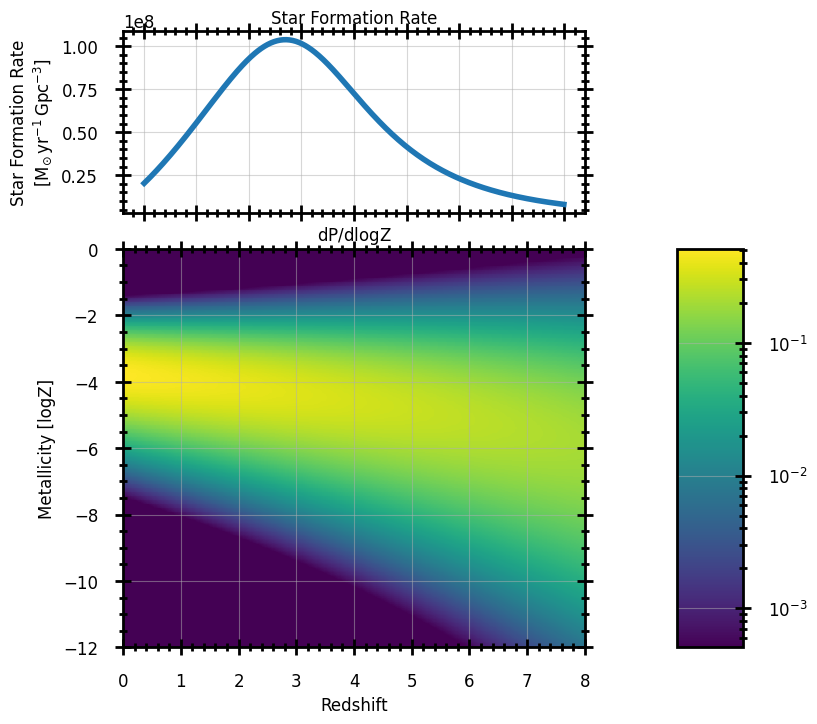

In [ ]:
import numpy as np
import astropy.units as u
import copy
import matplotlib.pyplot as plt

from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict

# Set up redshift bin info
num_redshifts = 400
redshift_bin_edges = np.linspace(0, 8, num_redshifts); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

# Set up metallicity bin info
num_metallicities = 500
log_metallicity_bin_edges = np.linspace(-12, 0, num_metallicities); log_metallicity_bin_centers = calculate_bincenters(log_metallicity_bin_edges)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)


#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

high_res_sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": log_metallicity_bin_edges,
    "metallicity_distribution_array": dpdlogZ,  # We need to transpose!
}

axis_dict = plot_sfr_dict(
    high_res_sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=False,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)

In [11]:
help(plot_sfr_dict)

Help on function plot_sfr_dict in module syntheticstellarpopconvolve.SFR_dict_plotting_routines:

plot_sfr_dict(sfr_dict, time_type, metallicity_string='Z', metallicity_distribution_scale='linear', metallicity_distribution_multiply_by_metallicity_bin_sizes=False, metallicity_distribution_multiply_by_sfr=False, metallicity_distribution_max_logdiff=3, metallicity_distribution_cmap=None, return_axis_dict=False, figsize=None, fontsize=20)
    Function to plot the star formation rate

